# Import data
Import data from a file containing the preprocessed dataset.

In [1]:
import pandas as pd
import os

# depending on the OS the path to the data file is different
if os.name == 'nt':
    data = pd.read_csv(r'..\data\preprocessed-data-classification.csv')
    food_groups = pd.read_excel(r'..\data\food-groups.xls')
elif os.name == 'posix':
    data = pd.read_csv(r'../data/preprocessed-data-classification.csv')
    food_groups = pd.read_excel(r'../data/food-groups.xls')

# filter food groups with 'Food Group Code' with length 2
food_groups = food_groups[food_groups['Food Group Code'].apply(lambda x: len(str(x)) == 2)]

data.head()

,Public Food Key,Classification,Food Name,"Energy with dietary fibre, equated \n(kJ)","Energy, without dietary fibre, equated \n(kJ)",Moisture (water) \n(g),Protein \n(g),Nitrogen \n(g),"Fat, total \n(g)",Ash \n(g),...,C20:5w3 (mg),C22:5w3 (mg),C22:4w6 (mg),C22:6w3 (mg),"Total polyunsaturated fatty acids, equated \n(g)","Total long chain omega 3 fatty acids, equated \n(mg)","Total trans fatty acids, imputed \n(mg)",Cholesterol \n(mg),Tryptophan \n(mg/gN),Tryptophan \n(mg)
0,F002258,31,"Cardamom seed, dried, ground",1236,1012,8.3,10.8,1.72,6.7,5.8,...,0.00,0.00,NaN,0.0,1.39,0.000,0.0,0,90.0,155
1,F002893,31,"Chilli (chili), dried, ground",1280,1002,10.8,13.4,2.14,14.3,11.8,...,0.00,0.00,NaN,0.0,6.69,0.000,0.0,0,32.0,69
2,F002963,31,"Cinnamon, dried, ground",1004,579,10.6,4.0,0.64,1.2,3.6,...,0.00,0.00,NaN,0.0,0.12,0.000,0.0,0,77.0,49
3,F002970,31,"Cloves, dried, ground",1389,1118,9.9,6.0,0.96,13.0,5.6,...,11.06,255.52,NaN,0.0,5.03,266.581,0.0,0,31.0,30
4,F003190,31,"Coriander seed, dried, ground",1344,1009,8.9,12.4,1.98,17.8,6.0,...,0.00,0.00,NaN,0.0,1.82,0.000,0.0,0,90.0,178


---
# Prepare data
1. Determine the target variable.
2. Determine the features.
3. Split the data into training and test sets.

In [2]:
# use nutrition columns as features
X_COLS = list(data.columns[3:])

# use classification column as target
y_COL = data.columns[1]

print(f"X_COLS: {X_COLS}")
print(f"y_COL: {y_COL}")

X_COLS: ['Energy with dietary fibre, equated \n(kJ)', 'Energy, without dietary fibre, equated \n(kJ)', 'Moisture (water) \n(g)', 'Protein \n(g)', 'Nitrogen \n(g)', 'Fat, total \n(g)', 'Ash \n(g)', 'Total dietary fibre \n(g)', 'Fructose \n(g)', 'Glucose \n(g)', 'Sucrose\n(g)', 'Total sugars (g)', 'Added sugars (g)', 'Free sugars \n(g)', 'Starch \n(g)', 'Available carbohydrate, without sugar alcohols \n(g)', 'Available carbohydrate, with sugar alcohols \n(g)', 'Malic acid\n (g)', 'Calcium (Ca) \n(mg)', 'Chloride (Cl) \n(mg)', 'Copper (Cu) \n(mg)', 'Iodine (I) \n(ug)', 'Iron (Fe) \n(mg)', 'Magnesium (Mg) \n(mg)', 'Manganese (Mn) \n(mg)', 'Phosphorus (P) \n(mg)', 'Potassium (K) \n(mg)', 'Selenium (Se) \n(ug)', 'Sodium (Na) \n(mg)', 'Sulphur (S) \n(mg)', 'Zinc (Zn) \n(mg)', 'Retinol (preformed vitamin A) \n(ug)', 'Beta-carotene \n(ug)', 'Beta-carotene equivalents (provitamin A) \n(ug)', 'Vitamin A retinol equivalents \n(ug)', 'Thiamin (B1) \n(mg)', 'Riboflavin (B2) \n(mg)', 'Niacin (B3) \n(

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, test = train_test_split(data, test_size=0.15, random_state=43)

# create design matrix X and predictions y
X_train = train[X_COLS]
y_train = train[y_COL]
X_test = test[X_COLS]
y_test = test[y_COL]

---
# $k$-nn
We create a $k$-nn model which is used to classify a food into different food groups based on its nutritional information.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# create knn with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=4)

# replace NaN values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# train the model using the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [5]:
# predict the labels of the test set
y_pred = knn.predict(X_test)

In [6]:
# check the accuracy
from sklearn.metrics import accuracy_score

# y_test constains the true labels of the test set
# y_pred contains the predicted labels of the test set
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# compare manually predicted labels with the true labels
print(f"First few predictions: {y_pred[:10]}")
print(f"First few true labels: {y_test[:10].values}")

Accuracy: 0.831275720164609
First few predictions: [24 22 16 12 18 18 28 13 24 12]
First few true labels: [24 22 24 31 18 31 28 31 19 13]


Correct predictions per food group:
24: 26 (Vegetable products and dishes)
22: 3 (Seed and nut products and dishes)
31: 6 (Miscellaneous)
18: 84 (Meat, poultry and game products and dishes)
28: 2 (Confectionery and cereal/nut/fruit/seed bars)
19: 7 (Milk products and dishes)
13: 8 (Cereal based products and dishes)
15: 17 (Fish and seafood products and dishes)
16: 8 (Fruit products and dishes)
11: 7 (Non-alcoholic beverages)
12: 23 (Cereals and cereal products)
14: 7 (Fats and oils)
23: 4 (Savoury sauces and condiments)


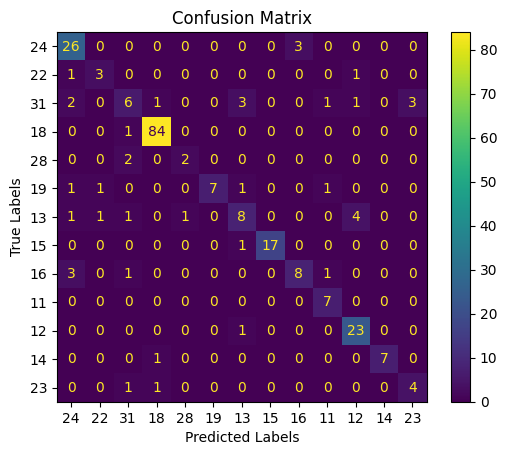

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# count the number of correct predictions
print("Correct predictions per food group:")
for value in y_test.unique():
    correct = 0
    for i in range(len(y_test)):
        if y_test.values[i] == y_pred[i] and y_test.values[i] == value:
            correct += 1
    food_group_name = food_groups[food_groups['Food Group Code'] == value]['Food Group and Sub-Group Name'].values[0].strip()
    print(f"{value}: {correct} ({food_group_name})")

# create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

# create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot confusion matrix
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# plot the labels on the x and y axis
plt.xticks(range(len(y_test.unique())), y_test.unique())
plt.yticks(range(len(y_test.unique())), y_test.unique())

plt.show()